In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import time
import glob
import gc

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
jax.config.update('jax_enable_x64', True)


%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times'

sys.path.insert(0, os.path.abspath(os.path.join('../')))
sys.path.insert(0, os.path.abspath(os.path.join('../../laplax/')))

## Find MAP

In [2]:
from geometric_bayesian.utils import DataLoader

num_samples_1, num_samples_2 = 100, 100
samples_c1 = jax.random.multivariate_normal(jax.random.key(0), jnp.array([-1,-1]), 0.2*jnp.eye(2), shape=(num_samples_1,))
targets_c1 = jnp.zeros(num_samples_1)
samples_c2 = jax.random.multivariate_normal(jax.random.key(0), jnp.array([1,1]), 0.2*jnp.eye(2), shape=(num_samples_2,))
targets_c2 = jnp.ones(num_samples_2)

samples = jnp.concatenate((samples_c1,samples_c2), axis=0)
targets = jnp.concatenate((targets_c1,targets_c2))
train_loader = DataLoader(samples, targets, 30, shuffle=True)

In [3]:
from geometric_bayesian.models import MLP
model = MLP(
    layers=[2,1],
    use_bias=False,
    param_dtype=jax.numpy.float64
)
num_params = model.size

In [4]:
from geometric_bayesian.densities import Bernoulli, MultivariateNormal
from geometric_bayesian.functions.likelihood import neg_logll
from geometric_bayesian.operators import DiagOperator

p_ll = lambda f : Bernoulli(f, logits=True)
prior_var = DiagOperator(
    diag = jnp.array(10.), 
    dim = num_params
)
p_prior = MultivariateNormal(cov=prior_var)

In [5]:
import optax
from flax import nnx

n_epochs = 1000
step_size = 1e-3
optimizer = nnx.Optimizer(model, optax.adam(step_size))

def loss_fn(model, x, y):
    y_pred = model(x)
    return neg_logll(p_ll, y, y_pred) - p_prior(model.params)/y.shape[0]

@nnx.jit
def train_step(model, optimizer, x, y):
    loss, grads = nnx.value_and_grad(loss_fn)(model, x, y)
    optimizer.update(grads) 
    return loss

In [6]:
losses = []
for epoch in range(n_epochs):
    for x_tr, y_tr in train_loader:
        losses.append(train_step(model, optimizer, x_tr, y_tr))

    if epoch % 100 == 0:
        print(f"[epoch {epoch}]: loss: {losses[-1]:.4f}")

print(f'{optimizer.step.value = }')
print(f"Final loss: {losses[-1]:.4f}")

[epoch 0]: loss: 0.4708
[epoch 100]: loss: 0.2842
[epoch 200]: loss: 0.2014
[epoch 300]: loss: 0.1670
[epoch 400]: loss: 0.1895
[epoch 500]: loss: 0.1637
[epoch 600]: loss: 0.1708
[epoch 700]: loss: 0.1649
[epoch 800]: loss: 0.1732
[epoch 900]: loss: 0.1706
optimizer.step.value = Array(7000, dtype=uint32)
Final loss: 0.1676


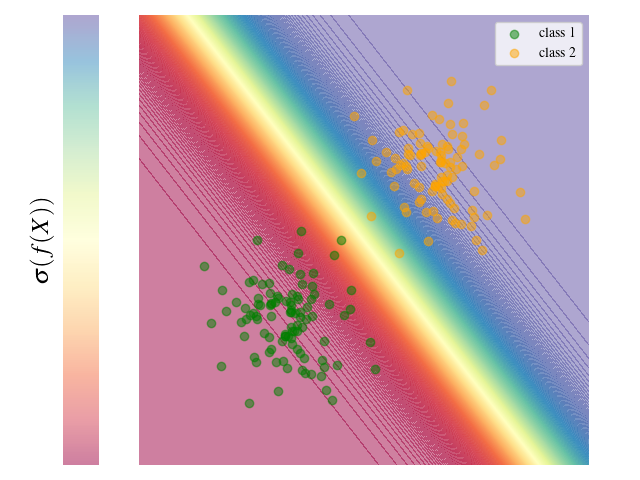

In [7]:
from geometric_bayesian.utils.plot import contour_plot, surf_plot
fig = contour_plot(lambda x: jax.nn.sigmoid(model(x)), min=[-3, -3], max=[3, 3], res=100, iso=False, alpha=0.5, zorder=-1, label='\sigma(f(X))')
ax = fig.axes[0]
ax.scatter(samples_c1[:,0], samples_c1[:,1], label='class 1', color='green', alpha=0.5)
ax.scatter(samples_c2[:,0], samples_c2[:,1], label='class 2', color='orange', alpha=0.5)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.set_aspect('equal', 'box')
ax.legend()

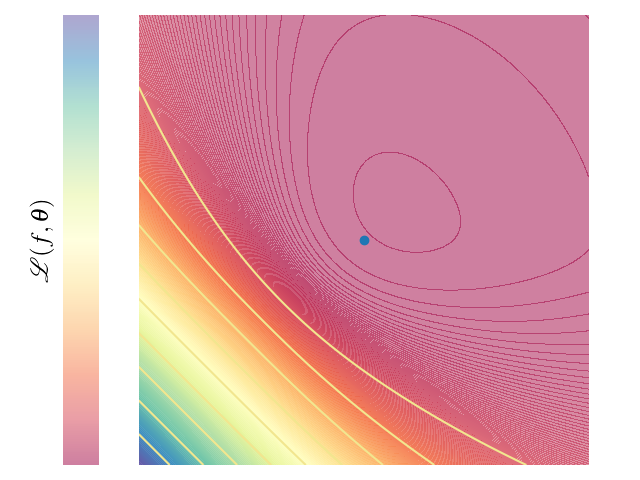

In [8]:
def loss(params):
    return neg_logll(p_ll, targets, model.fwd_params()(samples, params)) - p_prior(params)/targets.shape[0]
p_min, p_max = model.params-10, model.params+10
fig = contour_plot(jax.vmap(loss), min=p_min, max=p_max, res=100, iso=True, alpha=0.5, zorder=-1, label=r'\mathcal{L}(f,\theta)')

# fig = contour_plot(jax.vmap(loss), min=p_min, max=p_max, res=100, fig=None)
ax = fig.axes[0]
ax.scatter(*model.params)

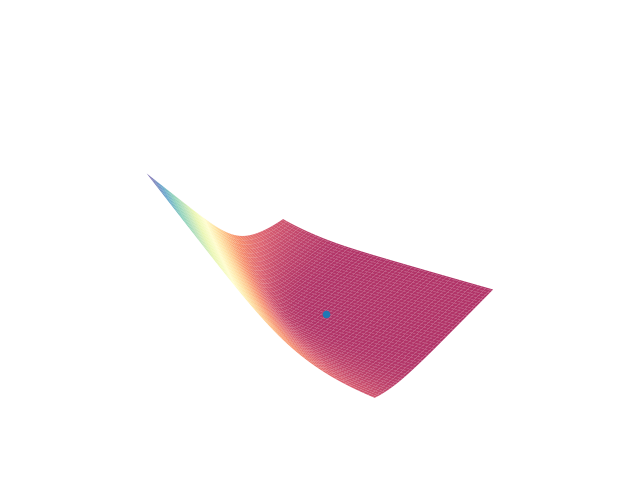

In [9]:
fig = surf_plot(jax.vmap(loss), min=p_min, max=p_max, res=100)
ax = fig.axes[0]
ax.scatter(*jnp.append(model.params,loss(model.params)))

## Laplace Approximation

In [10]:
from geometric_bayesian.curv.ggn import ggn
from geometric_bayesian.utils.helper import wrap_pytree_function
from geometric_bayesian.operators.psd_operator import PSDOperator

ggn_fn = wrap_pytree_function(
    ggn(
        p = p_ll,
        f = model,
        X = samples,
        y = targets,
        scaling = float(samples.shape[0])
    ), 
    nnx.state(model)
)
ggn_lr = PSDOperator(lambda v : ggn_fn(model.params, v), op_size=num_params).lowrank(num_modes=num_params)
cov_op = (ggn_lr + p_prior._cov.inverse()).inverse()
posterior = MultivariateNormal(cov=cov_op, mean=model.params)

/Users/bernardo/Repos/geometric-bayesian/geometric_bayesian/operators/linear_operator.py:104: UserWarning: Default `inverse` methods.
  warnings.warn("Default `inverse` methods.")


In [11]:
from geometric_bayesian.integrate import integrate, ef, ode23, ode45
dt, T = 0.01, 5.0
params_samples = posterior.sample(size=10)
x0 = jnp.expand_dims(model.params, axis=0).repeat(params_samples.shape[1],axis=0)
v0 = params_samples.T - x0

/Users/bernardo/Repos/geometric-bayesian/geometric_bayesian/operators/linear_operator.py:60: UserWarning: Default `dense` methods.
  warnings.warn("Default `dense` methods.")


In [12]:
from geometric_bayesian.approx.mc import pred_posterior_mean, pred_posterior_std, pred_posterior
mean_fn = pred_posterior_mean(model, params_samples)
std_fn = pred_posterior_std(model, params_samples)
pred_posterior_fn = pred_posterior(model, params_samples, p_ll)

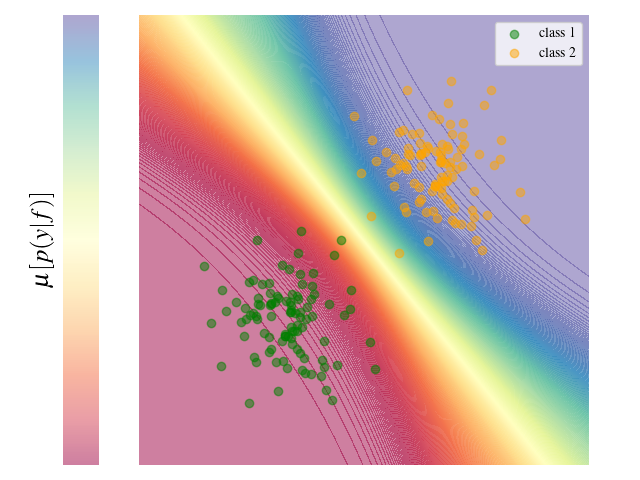

In [27]:
from geometric_bayesian.utils.plot import contour_plot, surf_plot
fig = contour_plot(mean_fn, min=[-3, -3], max=[3, 3], res=100, iso=False, alpha=0.5, zorder=-1, label=r'\mu[p(y|f)]')
ax = fig.axes[0]
ax.scatter(samples_c1[:,0], samples_c1[:,1], label='class 1', color='green', alpha=0.5)
ax.scatter(samples_c2[:,0], samples_c2[:,1], label='class 2', color='orange', alpha=0.5)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.set_aspect('equal', 'box')
ax.legend()

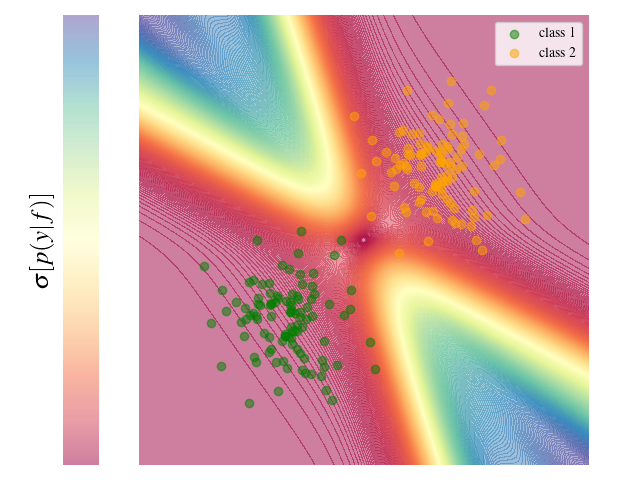

In [28]:
from geometric_bayesian.utils.plot import contour_plot, surf_plot
fig = contour_plot(std_fn, min=[-3, -3], max=[3, 3], res=100, iso=False, alpha=0.5, zorder=-1, label=r'\sigma[p(y|f)]')
ax = fig.axes[0]
ax.scatter(samples_c1[:,0], samples_c1[:,1], label='class 1', color='green', alpha=0.5)
ax.scatter(samples_c2[:,0], samples_c2[:,1], label='class 2', color='orange', alpha=0.5)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.set_aspect('equal', 'box')
ax.legend()

## Pullback Embedding Geometry

In [15]:
from geometric_bayesian.geom.embedding import pullmetric, christoffel_sk

def embedding(x):
    return jnp.array([*x, loss(x)])

csk_pull = christoffel_sk(embedding)

@jax.jit
def dynamics_pull(t,x,u):
    x1, x2 = jnp.split(x, 2)
    return jnp.append(x2, -csk_pull(x1,x2))

metric_pull = lambda x, v : pullmetric(embedding)(x, v)
print("Metric at MAP:", jax.lax.map(lambda v: metric_pull(model.params,v), jnp.eye(num_params)))

Metric at MAP: [[1.00006827e+00 7.05740432e-05]
 [7.05740432e-05 1.00007295e+00]]


In [16]:
step = integrate(
    f = dynamics_pull,
    dt = dt,
    T = T,
    integrator = ode45,
)

start = time.time()
trajectory_pull = jax.vmap(step)(jnp.hstack((x0, v0)))
print(time.time() - start)

0.4960160255432129


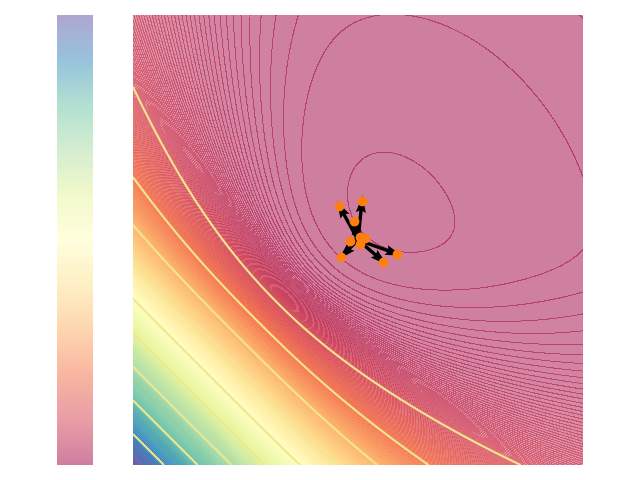

In [17]:
fig = contour_plot(jax.vmap(loss), min=p_min, max=p_max, res=100, alpha=0.5, zorder=-1)
ax = fig.axes[0]
# for i in range(v0.shape[0]):
#     traj = trajectory_pull[0][i]
#     ax.plot(traj[:, 0], traj[:, 1], color="k")
ax.scatter(*model.params)
ax.quiver(x0[:,0], x0[:,1], params_samples.T[:,0]- x0[:,0], params_samples.T[:,1]- x0[:,1])
ax.scatter(params_samples.T[:,0], params_samples.T[:,1])

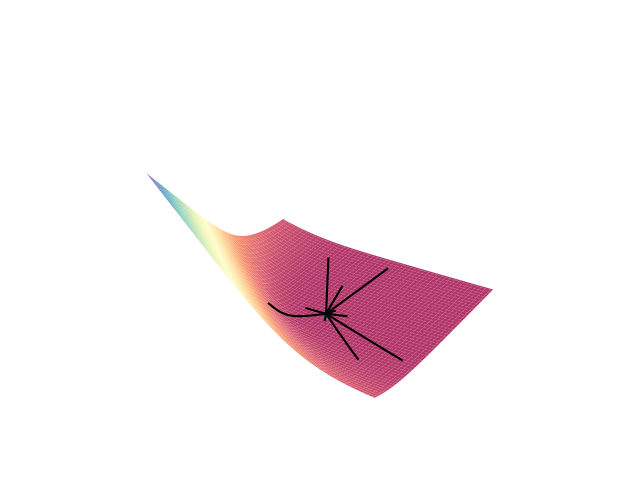

In [18]:
fig = surf_plot(jax.vmap(loss), min=p_min, max=p_max, res=100, fig=None)
ax = fig.axes[0]
ax.scatter(*jnp.append(model.params,loss(model.params)))
for i in range(v0.shape[0]):
    traj = trajectory_pull[0][i]
    ax.plot(
        traj[:, 0], 
        traj[:, 1],
        jax.vmap(loss)(jnp.vstack((traj[:, 0], traj[:, 1])).T),
        color="k")

## GGN Metric Geometry

In [19]:
from geometric_bayesian.geom.metric import christoffel_sk

csk_ggn = christoffel_sk(ggn_fn)
@jax.jit
def dynamics_ggn(t,x,u):
    x1, x2 = jnp.split(x, 2)
    return jnp.append(x2, -csk_ggn(x1,x2))

print("Metric:", jax.lax.map(lambda v : ggn_fn(model.params, v), jnp.eye(num_params)))
D,U = jnp.linalg.eigh(jax.lax.map(lambda v : ggn_fn(model.params, v), jnp.eye(num_params)))
print("Eigvals:", D)
print("Eigvecs:", U)

Metric: [[1.52303247 0.98577474]
 [0.98577474 1.82905805]]
Eigvals: [0.67846581 2.67362471]
Eigvecs: [[-0.75940242  0.65062122]
 [ 0.65062122  0.75940242]]


In [20]:
step = integrate(
    f = dynamics_ggn,
    dt = dt,
    T = 1.0,
    integrator = ode45,
)

start = time.time()
trajectory_ggn = jax.vmap(step, in_axes=0)(jnp.hstack((x0, v0)))
print(time.time() - start)

0.21584105491638184


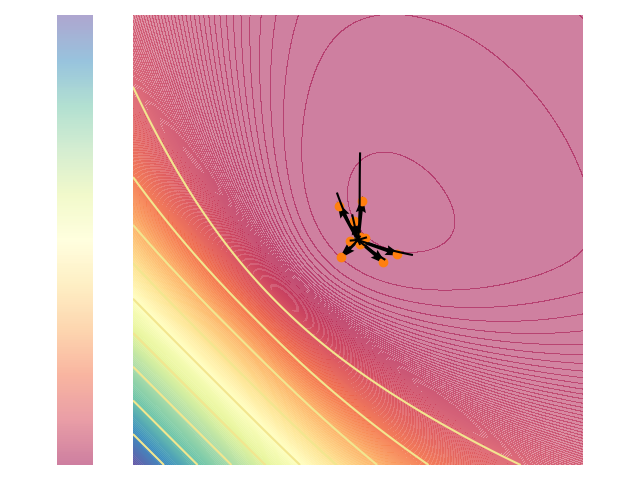

In [21]:
fig = contour_plot(jax.vmap(loss), min=p_min, max=p_max, res=100, alpha=0.5, zorder=-1)
ax = fig.axes[0]
for i in range(v0.shape[0]):
    traj = trajectory_ggn[0][i]
    ax.plot(traj[:, 0], traj[:, 1], color="k")
ax.scatter(*model.params)
ax.quiver(x0[:,0], x0[:,1], params_samples.T[:,0]- x0[:,0], params_samples.T[:,1]- x0[:,1])
ax.scatter(params_samples.T[:,0], params_samples.T[:,1])